In [1]:
import joblib
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import sys 
import os 
from pathlib import Path 
import numpy as np 
import joblib

%load_ext autoreload
%autoreload 2

import pandas as pd
import shap 
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import umap

import matplotlib.pyplot as plt 
%matplotlib inline 

import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'

DATADIR = '../data'
TRAIN_SIZE = 0.7


import sys 
sys.path.append('../')
from dispersant_screener.definitions import FEATURES
from dispersant_screener.utils import plot_parity
from dispersant_screener.ga import FEATURES


import wandb
from lightgbm import LGBMRegressor

df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([
    rg.reshape(-1, 1),
    -1* gibbs.reshape(-1, 1),
    gibbs_max.reshape(-1, 1),
])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

In [47]:
ga_0 = joblib.load('../work/20200824-094216-ga_0.joblib')
ga_0_2 = joblib.load('../work/20200824-164656-ga_0.joblib')

ga_1 = joblib.load('../work/20200824-132045-ga_1.joblib')
ga_1_2 = joblib.load('../work/20200824-142837-ga_1.joblib')
ga_1_3 = joblib.load('../work/20200824-161410-ga_2.joblib')

ga_2 = joblib.load('../work/20200824-151056-ga_2.joblib')
ga_2_2 = joblib.load('../work/20200824-153446-ga_2.joblib')
ga_2_3 = joblib.load('../work/20200824-161410-ga_2.joblib')

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


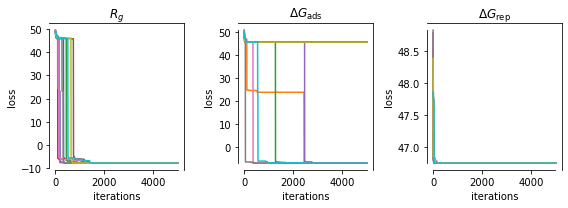

In [43]:
plt.rcParams['font.family'] = 'sans-serif'
    
fig, ax = plt.subplots(1,3, sharex='all', figsize=(8,3))

for a in ax:
    a.spines['left'].set_smart_bounds(True)
    a.spines['bottom'].set_smart_bounds(True)
    a.set_xlabel('iterations')
    a.set_ylabel('loss')
    
for ga in ga_0: 
    ax[0].plot(ga.report)
    
for ga in ga_1_2: 
    ax[1].plot(ga.report)
        
for ga in ga_2_3: 
    ax[2].plot(ga.report)
    

ax[0].set_title(r'$R_g$')
ax[1].set_title(r'$\Delta G_{\mathrm{ads}}$')
ax[2].set_title(r'$\Delta G_{\mathrm{rep}}$')

fig.tight_layout()

fig.savefig('ga_gbdt_convergence_2.pdf', bbox_inches='tight')

In [10]:
ga_0[0].output_dict

{'variable': array([ 9.        , 10.        , 11.        , 12.        ,  0.25549786,
         0.26593742,  0.25558264,  0.24406403, 47.        ]),
 'function': -7.6298884153144675}

In [48]:
def get_converged_ga_feat_val(gas): 
    feats = []
    vals = []
    for ga in gas: 
        if ga.output_dict['function'] < 0:
            feats.append(ga.output_dict['variable'])
            vals.append(ga.output_dict['function'])
            
    return feats, vals

In [44]:
vals_0

[-7.737162617800036,
 -7.756364540429496,
 -7.756249692411778,
 -7.720898771082702,
 -7.737162621821824,
 -7.756364541257404,
 -7.7284938773376695,
 -7.756410884300824,
 -7.737063024113377,
 -7.75636454076793]

In [59]:
feat_0_1, vals_0_1 = get_converged_ga_feat_val(ga_0)
feat_0_2, vals_0_2 = get_converged_ga_feat_val(ga_0_2)
feat_1_1, vals_1_1 = get_converged_ga_feat_val(ga_1)
feat_1_2, vals_1_2 = get_converged_ga_feat_val(ga_1_2)
feat_2_1, vals_2_1 = get_converged_ga_feat_val(ga_2)
feat_2_2, vals_2_2 = get_converged_ga_feat_val(ga_2_2)

In [60]:
feat_0 = []
feat_0.extend(feat_0_1)
feat_0.extend(feat_0_2)

In [61]:
feat_1 = []
feat_1.extend(feat_1_1)
feat_1.extend(feat_1_2)

In [62]:
feat_2 = []
feat_2.extend(feat_2_1)
feat_2.extend(feat_2_2)

In [63]:
scaler = StandardScaler()
X = scaler.fit_transform(df_full_factorial_feat)

In [64]:
feat_0_scaled = scaler.transform(feat_0)
feat_1_scaled = scaler.transform(feat_1)
feat_2_scaled = scaler.transform(feat_2)

In [65]:
pca = PCA(2)

In [66]:
X_pca = pca.fit_transform(X)

In [17]:
feat_0_scaled_pca = pca.transform(feat_0_scaled)
feat_1_scaled_pca = pca.transform(feat_1_scaled)
feat_2_scaled_pca = pca.transform(feat_2_scaled)


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


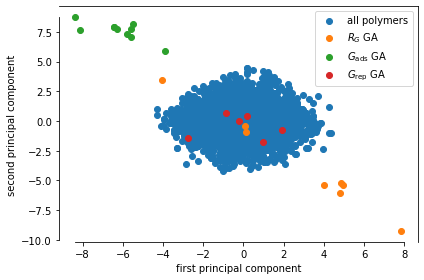

In [18]:
fig, ax = plt.subplots(1,1)
ax.scatter(X_pca[:,0], X_pca[:,1], label='all polymers')
ax.scatter(feat_0_scaled_pca[:,0], feat_0_scaled_pca[:,1], label=r'$R_G$ GA')
ax.scatter(feat_1_scaled_pca[:,0], feat_1_scaled_pca[:,1], label=r'$G_\mathrm{ads}$ GA')
ax.scatter(feat_2_scaled_pca[:,0], feat_2_scaled_pca[:,1], label=r'$G_\mathrm{rep}$ GA')


ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)


ax.set_xlabel('first principal component')
ax.set_ylabel('second principal component')
ax.legend()

fig.tight_layout()
fig.savefig('ga_gbdt_pca.pdf', bbox_inches='tight')
#

In [19]:
reducer = umap.UMAP()

In [20]:
embedding = reducer.fit_transform(X)

In [21]:
feat_0_scaled_umap = reducer.transform(feat_0_scaled)
feat_1_scaled_umap = reducer.transform(feat_1_scaled)
feat_2_scaled_umap = reducer.transform(feat_2_scaled)


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


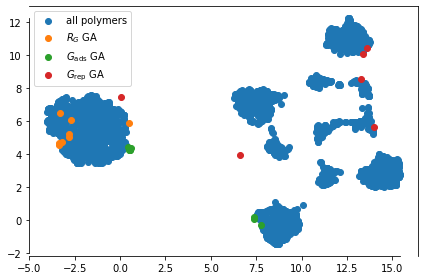

In [22]:
fig, ax = plt.subplots(1,1)
ax.scatter(embedding[:,0], embedding[:,1], label='all polymers')
ax.scatter(feat_0_scaled_umap[:,0], feat_0_scaled_umap[:,1], label=r'$R_G$ GA')
ax.scatter(feat_1_scaled_umap[:,0], feat_1_scaled_umap[:,1], label=r'$G_\mathrm{ads}$ GA')
ax.scatter(feat_2_scaled_umap[:,0], feat_2_scaled_umap[:,1], label=r'$G_\mathrm{rep}$ GA')


ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

ax.legend()

fig.tight_layout()

fig.savefig('umap_ga_gbdt.pdf', bbox_inches='tight')

In [67]:
# Rg
config_0 = {
    'max_depth': 81,
    'reg_alpha': 1.0059223601214005,
    'subsample': 0.4323683292622177,
    'num_leaves': 14,
    'reg_lambda': 1.3804842496500522,
    'n_estimators': 3771,
    'colsample_bytree': 0.9897619355459844,
    'min_child_weight': 0.036693782744867405
}

# Delta G
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/wog4qfb2/overview?workspace=user-kjappelbaum
config_1 = {
    'max_depth': 73,
    'reg_alpha': 1.392732983015451,
    'subsample': 0.5009306968568509,
    'num_leaves': 6,
    'reg_lambda': 1.0595847294980203,
    'n_estimators': 461,
    'colsample_bytree': 0.966043658485258,
    'min_child_weight': 0.0039362945584385705
}

# repulsion
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/ljzi9uad/overview?workspace=user-kjappelbaum
config_2 = {
    'max_depth': 22,
    'reg_alpha': 1.4445428983500173,
    'subsample': 0.37540621157955995,
    'num_leaves': 11,
    'reg_lambda': 1.246760700982355,
    'n_estimators': 56,
    'colsample_bytree': 0.9850898928749316,
    'min_child_weight': 0.05716405492260722
}


In [68]:
df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([
    rg.reshape(-1, 1),
    gibbs.reshape(-1, 1) * (-1),
    gibbs_max.reshape(-1, 1),
])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)


In [69]:
lgbms = []
for target in range(3):
    y_selected = y[:, target]
    X_train, X_test, y_train, y_test = train_test_split(df_full_factorial_feat, y_selected, train_size=0.8)
    if target == 0:
        lgbm = LGBMRegressor(**config_0)
    elif target == 1:
        lgbm = LGBMRegressor(**config_1)
    elif target == 2:
        lgbm = LGBMRegressor(**config_2)

    lgbm.fit(X_train, y_train)
    
    lgbms.append(lgbm)

In [70]:
pred_0 = lgbms[0].predict(feat_0_scaled)
pred_1 = lgbms[1].predict(feat_1_scaled)
pred_2 = lgbms[2].predict(feat_2_scaled)

In [71]:
import seaborn as sns

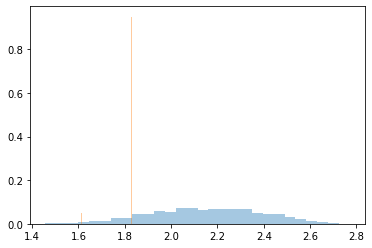

In [72]:
sns.distplot(y[:,0], kde=False, hist_kws={'weights': np.full(len(y), 1/len(y))})
sns.distplot(pred_0, kde=False, hist_kws={'weights': np.full(len(pred_0), 1/len(pred_0))})

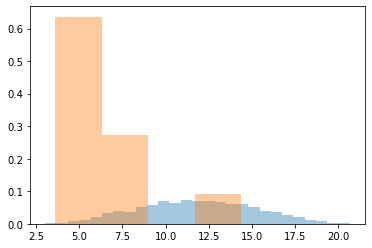

In [73]:
sns.distplot(y[:,1], kde=False, hist_kws={'weights': np.full(len(y), 1/len(y))})
sns.distplot(pred_1, kde=False, hist_kws={'weights': np.full(len(pred_1), 1/len(pred_1))})

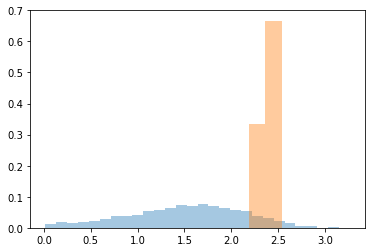

In [74]:
sns.distplot(y[:,2], kde=False, hist_kws={'weights': np.full(len(y), 1/len(y))})
sns.distplot(pred_2, kde=False, hist_kws={'weights': np.full(len(pred_2), 1/len(pred_2))})

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


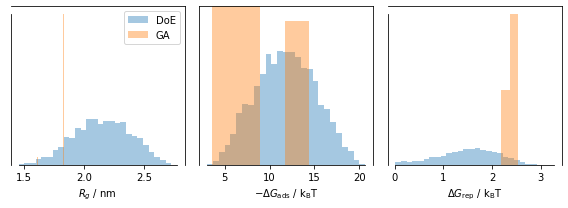

In [77]:
plt.rcParams['font.family'] = 'sans-serif'
    
fig, ax = plt.subplots(1,3,  figsize=(8,3), sharey='none')

for a in ax:
    a.spines['left'].set_smart_bounds(True)
    a.spines['bottom'].set_smart_bounds(True)
    a.set_yticks([])
    
sns.distplot(y[:,0], kde=False, hist_kws={'weights': np.full(len(y), 4/len(y))}, ax=ax[0], label='DoE')
sns.distplot(pred_0, kde=False, hist_kws={'weights': np.full(len(pred_0), 1/len(pred_0))}, ax=ax[0], label='GA')
    
sns.distplot(y[:,1], kde=False, hist_kws={'weights': np.full(len(y), 1/len(y))}, ax=ax[1])
sns.distplot(pred_1, kde=False, hist_kws={'weights': np.full(len(pred_1), 1/len(pred_1))}, ax=ax[1])

ax[1].set_ylim(0,0.1)
    
sns.distplot(y[:,2], kde=False, hist_kws={'weights': np.full(len(y), 1/len(y))}, ax=ax[2])
sns.distplot(pred_2, kde=False, hist_kws={'weights': np.full(len(pred_2), 1/len(pred_2))}, ax=ax[2])

ax[0].set_xlabel('$R_g$ / nm')
ax[1].set_xlabel('$-\Delta G_\mathrm{ads}$ / k$_\mathrm{B}$T')
ax[2].set_xlabel('$\Delta G_\mathrm{rep}$ / k$_\mathrm{B}$T')
ax[0].legend()
fig.tight_layout()
plt.savefig('ga_property_dist_gpr.pdf', bbox_inches='tight')

In [80]:
from scipy.spatial.distance import cdist

In [91]:
dist_mat = cdist(X, X)

In [101]:
np.fill_diagonal(dist_mat, np.inf)
dist_mat.min(axis=1).mean()

0.8305744643248172

In [103]:
np.min(np.linalg.norm(np.array([ 0. ,         0.       ,   0.    ,      2.   ,       0.34386723 , 0.31900125,
  0.15639876 , 0.09377703, 16.        ]) - X, axis=1))

13.259122740534503

In [108]:
np.linalg.norm(np.array([ 0. ,         0.       ,   0.    ,      2.   ,       0.34386723 , 0.31900125,
  0.15639876 , 0.09377703, 16.        ]) - X, axis=1)

array([18.9574964 , 18.88990211, 19.1505382 , ..., 13.2593011 ,
       13.33044388, 13.37906018])